In [1]:
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from typing import Callable, Dict, Tuple, List

np.set_printoptions(precision=4)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
TEST_ALL = False

# Boston data

In [4]:
from sklearn.datasets import load_boston

In [5]:
boston = load_boston()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = boston.data
target = boston.target
features = boston.feature_names


s = StandardScaler()
data = s.fit_transform(data)

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=80718)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

# Neural network regression

In [7]:
def sigmoid(x: ndarray) -> ndarray:
    return 1 / (1 + np.exp(-1.0 * x))

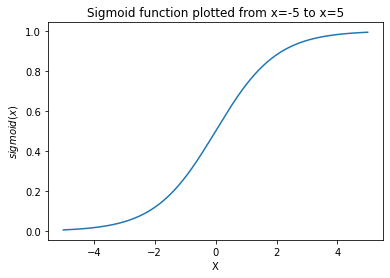

In [8]:
plt.plot(np.arange(-5, 5, 0.01),
         sigmoid(np.arange(-5, 5, 0.01)));
plt.title("Sigmoid function plotted from x=-5 to x=5")
plt.xlabel("X")
plt.ylabel("$sigmoid(x)$");

In [9]:
def permute_data(X: ndarray, y: ndarray):
    '''
    Permute X and y, using the same permutation, along axis=0
    '''
    perm = np.random.permutation(X.shape[0])
    return X[perm], y[perm]

In [10]:
Batch = Tuple[ndarray, ndarray]

def generate_batch(X: ndarray, 
                   y: ndarray,
                   start: int = 0,
                   batch_size: int = 10) -> Batch:
    '''
    Generate batch from X and y, given a start position
    '''
    assert X.ndim == y.ndim == 2, \
    "X and Y must be 2 dimensional"

    if start+batch_size > X.shape[0]:
        batch_size = X.shape[0] - start
    
    X_batch, y_batch = X[start:start+batch_size], y[start:start+batch_size]
    
    return X_batch, y_batch

In [11]:
def mae(preds: ndarray, actuals: ndarray):
    '''
    Compute mean absolute error.
    '''
    return np.mean(np.abs(preds - actuals))

def rmse(preds: ndarray, actuals: ndarray):
    '''
    Compute root mean squared error.
    '''
    return np.sqrt(np.mean(np.power(preds - actuals, 2)))

In [12]:
def init_weights(input_size: int, 
                 hidden_size: int) -> Dict[str, ndarray]:
    '''
    Initialize weights during the forward pass for step-by-step neural network model.
    '''
    weights: Dict[str, ndarray] = {}
    weights['W1'] = np.random.randn(input_size, hidden_size)
    weights['B1'] = np.random.randn(1, hidden_size)
    weights['W2'] = np.random.randn(hidden_size, 1)
    weights['B2'] = np.random.randn(1, 1)
    return weights


#### Fill in the missing code from the forward loss function, think about each step of the neural network (Matrix multplication, add bias, pass through non linear function, repeat MM for layer 2, add bias2).

In [13]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]
                 ) -> Tuple[Dict[str, ndarray], float]:
    '''
    Compute the forward pass and the loss for the step-by-step 
    neural network model.     
    '''
    #Fill in below
    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)
    
    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']
    #------------------------
    
    loss = np.mean(np.power(y - P, 2))
    
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['M1'] = M1
    forward_info['N1'] = N1
    forward_info['O1'] = O1
    forward_info['M2'] = M2
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

#### Solution:

In [ ]:
def forward_loss(X: ndarray,
                 y: ndarray,
                 weights: Dict[str, ndarray]
                 ) -> Tuple[Dict[str, ndarray], float]:
    '''
    Compute the forward pass and the loss for the step-by-step 
    neural network model.     
    '''
    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)
    
    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']    

    loss = np.mean(np.power(y - P, 2))
    
    forward_info: Dict[str, ndarray] = {}
    forward_info['X'] = X
    forward_info['M1'] = M1
    forward_info['N1'] = N1
    forward_info['O1'] = O1
    forward_info['M2'] = M2
    forward_info['P'] = P
    forward_info['y'] = y

    return forward_info, loss

### Gradients, Predictions, and Training:

In [14]:
def loss_gradients(forward_info: Dict[str, ndarray], 
                   weights: Dict[str, ndarray]) -> Dict[str, ndarray]:
    '''
    Compute the partial derivatives of the loss with respect to each of the parameters in the neural network.
    '''    
    dLdP = -(forward_info['y'] - forward_info['P'])
    
    dPdM2 = np.ones_like(forward_info['M2'])

    dLdM2 = dLdP * dPdM2
  
    dPdB2 = np.ones_like(weights['B2'])

    dLdB2 = (dLdP * dPdB2).sum(axis=0)
    
    dM2dW2 = np.transpose(forward_info['O1'], (1, 0))
    
    dLdW2 = np.dot(dM2dW2, dLdP)

    dM2dO1 = np.transpose(weights['W2'], (1, 0)) 

    dLdO1 = np.dot(dLdM2, dM2dO1)
    
    dO1dN1 = sigmoid(forward_info['N1']) * (1- sigmoid(forward_info['N1']))
    
    dLdN1 = dLdO1 * dO1dN1
    
    dN1dB1 = np.ones_like(weights['B1'])
    
    dN1dM1 = np.ones_like(forward_info['M1'])
    
    dLdB1 = (dLdN1 * dN1dB1).sum(axis=0)
    
    dLdM1 = dLdN1 * dN1dM1
    
    dM1dW1 = np.transpose(forward_info['X'], (1, 0)) 

    dLdW1 = np.dot(dM1dW1, dLdM1)

    loss_gradients: Dict[str, ndarray] = {}
    loss_gradients['W2'] = dLdW2
    loss_gradients['B2'] = dLdB2.sum(axis=0)
    loss_gradients['W1'] = dLdW1
    loss_gradients['B1'] = dLdB1.sum(axis=0)
    
    return loss_gradients

In [15]:
def predict(X: ndarray, 
            weights: Dict[str, ndarray]) -> ndarray:
    '''
    Generate predictions from the step-by-step neural network model. 
    '''
    M1 = np.dot(X, weights['W1'])

    N1 = M1 + weights['B1']

    O1 = sigmoid(N1)

    M2 = np.dot(O1, weights['W2'])

    P = M2 + weights['B2']    

    return P

In [22]:
def train(X_train: ndarray, y_train: ndarray,
          X_test: ndarray, y_test: ndarray,
          n_iter: int = 1000,
          test_every: int = 1000,
          learning_rate: float = 0.01,
          hidden_size= 13,
          batch_size: int = 100,
          return_losses: bool = False, 
          return_weights: bool = False, 
          seed: int = 1) -> None:

    if seed:
        np.random.seed(seed)

    start = 0

    # Initialize weights
    weights = init_weights(X_train.shape[1], 
                           hidden_size=hidden_size)

    # Permute data
    X_train, y_train = permute_data(X_train, y_train)
    

    losses = []

    for i in range(n_iter):

        # Generate batch
        if start >= X_train.shape[0]:
            X_train, y_train = permute_data(X_train, y_train)
            start = 0
        
        X_batch, y_batch = generate_batch(X_train, y_train, start, batch_size)
        start += batch_size
    
        # Train net using generated batch
        forward_info, loss = forward_loss(X_batch, y_batch, weights)

        if return_losses:
            losses.append(loss)

        loss_grads = loss_gradients(forward_info, weights)
        for key in weights.keys():
            weights[key] -= learning_rate * loss_grads[key]

    if return_weights:
        return losses, weights
    
    return None

In [17]:
if TEST_ALL:
    num_iter = 10000
    test_every = 1000
    train_info = train(X_train, y_train, X_test, y_test,
                       n_iter=num_iter,
                       test_every = test_every,
                       learning_rate = 0.001,
                       batch_size=23, 
                       return_losses=False, 
                       return_weights=True, 
                       return_scores=False,
                       seed=80718)
    losses = train_info[0]
    weights = train_info[1]
    val_scores = train_info[2]

In [18]:
if TEST_ALL:
    import matplotlib.pyplot as plt
    %matplotlib inline
    plt.ylim([-1,1])
    plt.plot(list(range(int(num_iter / test_every - 1))), val_scores); 
    plt.xlabel("Batches (000s)")
    plt.title("Validation Scores")

### Learning rate tuning

#### Pick 5 learning rates between 10e-2 and 10e-6, put them in a list. Loop through them and using the above train function, train the model using each learning rate. Using the above predict function, generate predictions and check the Mean Absolute Error (mae) and Root Mean Squared Error (rmse) for each learning rate and compare the results. 

In [23]:
#Code
rates = [10**-2, 10**-3, 10**-4, 10**-5, 10**-6]

for rate in rates:
  print("Learning rate: " + str(rate))
  train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=100000,
                   test_every = 1000,
                   learning_rate = rate,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180807)
  losses = train_info[0]
  weights = train_info[1]

  preds = predict(X=X_test, weights=weights)

  print("Mean Absolute Error: %f, Root Mean Squared Error: %f" % (mae(preds=preds, actuals=y_test), rmse(preds=preds, actuals=y_test)))
  print()
    



Learning rate: 0.01
Mean Absolute Error: 2.716529, Root Mean Squared Error: 3.614856

Learning rate: 0.001
Mean Absolute Error: 2.926838, Root Mean Squared Error: 4.241870

Learning rate: 0.0001
Mean Absolute Error: 2.460066, Root Mean Squared Error: 3.625732

Learning rate: 1e-05
Mean Absolute Error: 2.602288, Root Mean Squared Error: 4.133154

Learning rate: 1e-06
Mean Absolute Error: 3.807903, Root Mean Squared Error: 5.708256



#### Solution:

In [36]:
rates = [0.0001, 0.001, 0.0025, 0.005, 0.01]

for lr in rates:
    train_info = train(X_train, y_train, X_test, y_test,
                       n_iter=1000,
                       test_every = 1000,
                       learning_rate = lr,
                       batch_size=23, 
                       return_losses=True, 
                       return_weights=True, 
                       seed=180807)


    losses = train_info[0]
    weights = train_info[1]
    preds = predict(X_test, weights)
    print("For Learning Rate: ", lr)
    print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
          "Root mean squared error:", round(rmse(preds, y_test), 4), "\n")


For Learning Rate:  0.0001
Mean absolute error: 3.8296 
Root mean squared error: 5.7104 

For Learning Rate:  0.001
Mean absolute error: 2.6859 
Root mean squared error: 4.1541 

For Learning Rate:  0.0025
Mean absolute error: 2.5004 
Root mean squared error: 3.8419 

For Learning Rate:  0.005
Mean absolute error: 2.7075 
Root mean squared error: 4.1213 

For Learning Rate:  0.01
Mean absolute error: 2.3831 
Root mean squared error: 3.5471 



## Evaluating best model

In [ ]:
train_info = train(X_train, y_train, X_test, y_test,
                   n_iter=10000,
                   test_every = 1000,
                   learning_rate = 0.001,
                   batch_size=23, 
                   return_losses=True, 
                   return_weights=True, 
                   seed=180807)
losses = train_info[0]
weights = train_info[1]

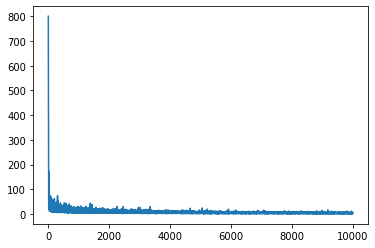

In [ ]:
plt.plot(list(range(10000)), losses);

In [ ]:
preds = predict(X_test, weights)

## Investigation of most important features

#### Print the final weights and determine the top 2 most important features:

In [ ]:
#Code



#### Solution:

In [ ]:
print(weights['W2'])

[[  6.8818]
 [  7.3908]
 [  5.632 ]
 [  7.2358]
 [  7.6253]
 [  6.754 ]
 [  3.3251]
 [  9.7287]
 [  5.6011]
 [-10.2469]
 [  5.5645]
 [  5.6762]
 [ -4.4088]]


At index 7 and index 9 have the greatest absolute value. Here are the combinations themselves:

In [28]:
weights['W1'][7]

array([  0.1016,  -4.458 ,   1.2472,   3.9503,   0.8336,  -2.5708,
       -10.1209,  -1.3865,  -1.2258,   0.7769,  -3.2335,   2.7414,
        -0.0285])

In [ ]:
weights['W1'][9]

array([-2.6785,  3.9213,  2.2398, -3.6323, -0.2241,  3.1889,  0.3231,
        0.4316, -1.9733,  0.2403, -1.4463, -0.5084,  1.5561])

### Error

In [ ]:
print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))

Mean absolute error: 2.5951 
Root mean squared error: 3.8851


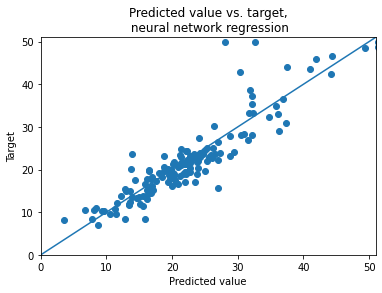

In [ ]:
plt.xlabel("Predicted value")
plt.ylabel("Target")
plt.title("Predicted value vs. target,\n neural network regression")
plt.xlim([0, 51])
plt.ylim([0, 51])
plt.scatter(preds, y_test)
plt.plot([0, 51], [0, 51]);


In [ ]:
np.round(np.mean(np.array(np.abs(preds - y_test))), 4)

2.5951

In [ ]:
np.round(np.mean(np.array(np.power(preds - y_test, 2))), 4)

15.0943

## Theoretical relationship between most important feature and target

In [ ]:
NUM = 40
a = np.repeat(X_test[:,:-1].mean(axis=0, keepdims=True), NUM, axis=0)
b = np.linspace(-1.5, 3.5, NUM).reshape(NUM, 1)
test_feature = np.concatenate([a, b], axis=1)
preds_test = predict(test_feature, weights)[:, 0]

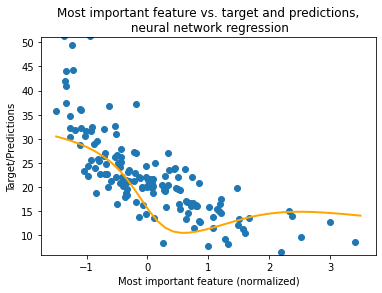

In [ ]:
plt.scatter(X_test[:, 12], preds)
plt.plot(np.array(test_feature[:, -1]), preds_test, linewidth=2, c='orange')
plt.ylim([6, 51])
plt.xlabel("Most important feature (normalized)")
plt.ylabel("Target/Predictions")
plt.title("Most important feature vs. target and predictions,\n neural network regression");


### Go to the following link: https://scikit-learn.org/stable/modules/linear_model.html

### Try any (or many) of the models on our earlier dataset. Train them with .fit() and generate predictions with .predict(). Compare the MAE and RMSE to the earlier model with different linear models from the link. Generate a scatterplot using matplotlib with the predictions and y_test to see the distribution of our predicted data.

Mean Absolute Error: 9.219235 
Root Mean Squared Error: 12.085982
Weights: [-0.8062  0.3021 -0.0424  0.7514 -1.4326  2.5559  0.3041 -2.0069  1.157
 -0.6863 -2.0706  0.7685 -3.8015]



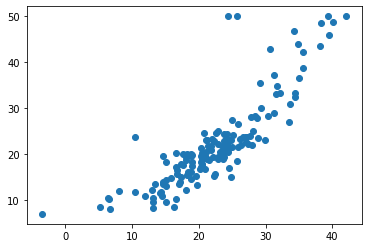

In [51]:
# Code
from sklearn import linear_model

model = linear_model.ElasticNet(alpha=0.1, max_iter=1000)
# model = linear_model.LinearRegression()
model.fit(X_train, y_train)

weights = model.coef_
preds = model.predict(X_test)

print("Mean Absolute Error: %f \nRoot Mean Squared Error: %f" % (mae(preds=preds, actuals=y_test), rmse(preds=preds, actuals=y_test)))
print("Weights:",weights)
print()
plt.scatter(preds, y_test);

### Solution:

Mean absolute error: 9.4033 
Root mean squared error: 12.3394
Weights: [-0.9914  0.6537  0.1924  0.7122 -2.1249  2.3909  0.6678 -2.6262  2.4579
 -1.6542 -2.3045  0.8343 -4.1689]


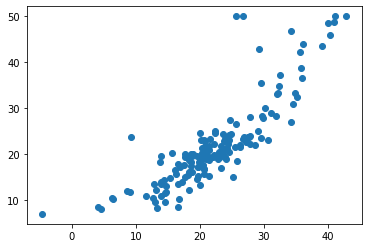

In [ ]:
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import utils

model = linear_model.Lasso(alpha=0.01)
model.fit(X_train,y_train)
weights = model.coef_
preds = model.predict(X_test)

print("Mean absolute error:", round(mae(preds, y_test), 4), "\n"
      "Root mean squared error:", round(rmse(preds, y_test), 4))
print("Weights:",weights)
plt.scatter(preds,y_test)
# plt.plot([0, 51], [0, 51]);



